# State Crash Data Preprocessing and EDA

This data was sourced from [Federal Motor Carrier Safety Administration](https://ai.fmcsa.dot.gov/CrashStatistics/?tab=Summary&type=&report_id=1&crash_type_id=4&datasource_id=1&time_period_id=2&report_date=2025&vehicle_type=1&state=AllStates&domicile=US&measure_id=1&operation_id=null) and reports data on all large truck and bus crashes between 2018 and 2025. 

The data was available for download as a .xlsx files so we uploaded it as a folder to the Local Filesystem and then copied it to GCS for persistent storage. 

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, month, year, avg, count
from pyspark.sql.types import StructType, StructField, StringType
import os
import pandas as pd
from functools import reduce
from pyspark.sql import DataFrame
import os
from pyspark.sql.functions import lit, col, to_date, month
from pyspark.sql.functions import col, count, sum, when, isnan, mean, corr, month, year, desc
from pyspark.sql.types import IntegerType, DoubleType, FloatType, DateType

In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("State Crash Data Analysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.jars.packages", 
            "com.crealytics:spark-excel_2.12:0.14.0,com.google.cloud.bigdataoss:gcs-connector:hadoop2-2.2.0") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
    .getOrCreate()

In [3]:
# Set path to your data folder 
data_path = "gs://ds5460-arvelo-bucket0311/notebooks/jupyter/state_crash_data"

# Create local directory if it doesn't exist
!mkdir -p /data/state_crash_data

# Copy recursively from GCS to local
!gsutil -m cp -r {data_path}/* /data/state_crash_data/

Copying gs://ds5460-arvelo-bucket0311/notebooks/jupyter/state_crash_data/AK_crash_250131.xlsx...
Copying gs://ds5460-arvelo-bucket0311/notebooks/jupyter/state_crash_data/AL_crash_250131.xlsx...
Copying gs://ds5460-arvelo-bucket0311/notebooks/jupyter/state_crash_data/AR_crash_250131.xlsx...
Copying gs://ds5460-arvelo-bucket0311/notebooks/jupyter/state_crash_data/CA_crash_250131.xlsx...
Copying gs://ds5460-arvelo-bucket0311/notebooks/jupyter/state_crash_data/KY_crash_250131.xlsx...
Copying gs://ds5460-arvelo-bucket0311/notebooks/jupyter/state_crash_data/CO_crash_250131.xlsx...
Copying gs://ds5460-arvelo-bucket0311/notebooks/jupyter/state_crash_data/AS_crash_250131.xlsx...
Copying gs://ds5460-arvelo-bucket0311/notebooks/jupyter/state_crash_data/AZ_crash_250131.xlsx...
Copying gs://ds5460-arvelo-bucket0311/notebooks/jupyter/state_crash_data/FL_crash_250131.xlsx...
Copying gs://ds5460-arvelo-bucket0311/notebooks/jupyter/state_crash_data/DC_crash_250131.xlsx...
Copying gs://ds5460-arvelo-buc

In [4]:
data_path = "/data/state_crash_data"

In [5]:
def read_state_year_data(state, year):
    file_path = f"{data_path}/{state}_crash_250131.xlsx"
    sheet_name = f"{state} {year} MCMIS"
    
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    
    try:
        # First check if the sheet exists
        excel_file = pd.ExcelFile(file_path)
        if sheet_name not in excel_file.sheet_names:
            print(f"Sheet '{sheet_name}' not found in {file_path}")
            print(f"Available sheets: {excel_file.sheet_names}")
            return None
            
        # Read the sheet
        pdf = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # Add state and year columns if they don't exist
        if "State" not in pdf.columns:
            pdf["State"] = state
        if "Crash Year" not in pdf.columns:
            pdf["Crash Year"] = year
            
        # Fix data type issues before converting to Spark DataFrame
        
        # Convert all numeric-looking strings to strings
        for col in pdf.columns:
            # Check if column contains date-like values
            if 'date' in col.lower() or 'time' in col.lower():
                # Convert to string to avoid date parsing issues
                pdf[col] = pdf[col].astype(str)
            # Handle potential mixed types
            elif pdf[col].dtype == 'object':
                # Convert to string to maintain consistency
                pdf[col] = pdf[col].astype(str)
        
        # Replace any NaN values with None for consistent null handling
        pdf = pdf.where(pd.notnull(pdf), None)
        
        # Create a schema where all fields are StringType
        fields = [StructField(col_name, StringType(), True) for col_name in pdf.columns]
        schema = StructType(fields)
        
        # Create Spark DataFrame with string schema
        df = spark.createDataFrame(pdf.astype(str), schema=schema)
        return df
    
    except Exception as e:
        print(f"Error reading {state} {year}: {str(e)}")
        return None

In [6]:
# Only Reading TN Data 

In [7]:
years = list(range(2023, 2026))

In [8]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [ ]:
# Process all files and combine into one dataframe
all_dfs = []

for state in states:  
    for year in years:  
        df = read_state_year_data(state, year)
        if df is not None:
            all_dfs.append(df)
        else:
            print(f"Failed to read data for {state} {year}")

In [ ]:
# Combine all dataframes if we found any
if all_dfs:
    # Union all dataframes
    all_data = reduce(DataFrame.unionByName, all_dfs)

In [ ]:
# Convert date string to date type
all_data = all_data.withColumn("Crash Date", to_date(col("Crash Date"), "MM/dd/yyyy"))

# Create month and year columns for analysis
all_data = all_data.withColumn("Crash Month", month("Crash Date"))

# Ensure Crash Year is numeric
all_data = all_data.withColumn("Crash Year", col("Crash Year").cast("integer"))

In [ ]:
all_data.cache()

DataFrame[Crash ID: string, Crash Year: int, Quarter-CY: string, Report State: string, Crash Date: date, Truck Bus Indicator: string, Fatal Count: string, Non Fatal Count: string, Fatalities: string, Injuries: string, Injury Count: string, Tow Away: string, Federal Recordable: string, State Recordable: string, Vehicles In Accident: string, City Code: string, City: string, County Code: string, County Name: string, State: string, Location: string, Trafficway Desc: string, Road Surface Condition Desc: string, Weather Condition Desc: string, Light Condition Desc: string, First Harmful Event: string, USDOT Number: string, Carrier Name: string, Carrier Street: string, Carrier City: string, Carrier State: string, Carrier Zip Code: string, Carrier Domicile: string, Carrier Add Date: string, New Entrant: string, Mexican Location: string, Interstate Carrier: string, State Number: string, State Issuing Number: string, Driver Age Category: string, Driver License State: string, Valid Driver License

## Basic EDA 

In [ ]:
total_rows = all_data.count()

In [ ]:
# Basic EDA
print("Total records:", total_rows)

Total records: 370407


In [ ]:
# Monthly crash counts overall
annual_counts = all_data.groupBy("Crash Year") \
    .count() \
    .orderBy("Crash Year")
annual_counts.show()

+----------+------+
|Crash Year| count|
+----------+------+
|      2023|184302|
|      2024|178943|
|      2025|  7162|
+----------+------+



In [ ]:
# Calculate missing values for each column
missing_counts = []

for column in df.columns:
    # Create explicit null check expression
    null_check = (col(column).isNull()) | (col(column) == '')

    # Get the column's data type from schema
    column_type = None
    for field in df.schema.fields:
        if field.name == column:
            column_type = field.dataType
            break

    # For numeric columns, also check for NaN values
    nan_count = 0
    if isinstance(column_type, (IntegerType, DoubleType, FloatType)):
        try:
            nan_count = df.filter(isnan(col(column))).count()
        except:
            # If isnan fails, just continue
            pass

    # Count null values
    try:
        null_count = df.filter(null_check).count() + nan_count
    except Exception as e:
        print(f"Error checking nulls for column {column}: {str(e)}")
        null_count = 0  # Default if error

    missing_pct = (null_count / total_rows) * 100
    missing_counts.append((column, null_count, missing_pct))

# Convert to pandas for better display
missing_df = pd.DataFrame(missing_counts, columns=['Column', 'Missing Count', 'Missing Percentage'])
missing_df = missing_df.sort_values('Missing Percentage', ascending=False)

Error checking nulls for column Crash Date.1: "Can't extract value from Crash Date#19970: need struct type but got string;"


In [ ]:
missing_df[missing_df["Missing Count"] != 0]

,Column,Missing Count,Missing Percentage


There is no missing data in this dataset!

In [ ]:
# Check for missigness in columns

In [ ]:
from pyspark.sql import functions as F

In [ ]:
monthly_county_counts = all_data.groupBy("Crash Year", 
                                         "Crash Month", 
                                         "State", 
                                         "County Code") \
                               .agg(F.count("*").alias("crash_count"),
                                    F.sum(F.col("Fatalities").cast("int")).alias("total_fatalities"),
                                    F.sum(F.col("Injuries").cast("int")).alias("total_injuries"),
                                    F.sum(F.col("Vehicles In Accident").cast("int")).alias("total_vehicles"))

In [ ]:
monthly_county_counts.printSchema()

root
 |-- Crash Year: integer (nullable = true)
 |-- Crash Month: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- County Code: string (nullable = true)
 |-- crash_count: long (nullable = false)
 |-- total_fatalities: long (nullable = true)
 |-- total_injuries: long (nullable = true)
 |-- total_vehicles: long (nullable = true)



In [ ]:
correlation_metrics = ["crash_count", "total_fatalities", "total_injuries", "total_vehicles"]

# Check if all metrics exist in the dataframe
available_metrics = [metric for metric in correlation_metrics if metric in monthly_county_counts.columns]

if len(available_metrics) >= 2:
    # Calculate correlations
    correlation_matrix = []
    
    for i, metric1 in enumerate(available_metrics):
        corr_row = []
        for j, metric2 in enumerate(available_metrics):
            if i == j:
                corr_row.append(1.0)  # Perfect correlation with itself
            else:
                # Calculate correlation
                try:
                    correlation = monthly_county_counts.stat.corr(metric1, metric2)
                    corr_row.append(correlation)
                except Exception as e:
                    print(f"Error calculating correlation between {metric1} and {metric2}: {str(e)}")
                    corr_row.append(None)  # Use None for failed correlations
        correlation_matrix.append(corr_row)
    
    # Convert to pandas for visualization
    corr_pd = pd.DataFrame(correlation_matrix, 
                          index=available_metrics, 
                          columns=available_metrics)
    
    print("Correlation matrix for key metrics:")
    print(corr_pd.round(3))

Correlation matrix for key metrics:
                  crash_count  total_fatalities  total_injuries  \
crash_count             1.000             0.437           0.851   
total_fatalities        0.437             1.000           0.440   
total_injuries          0.851             0.440           1.000   
total_vehicles          0.932             0.481           0.752   

                  total_vehicles  
crash_count                0.932  
total_fatalities           0.481  
total_injuries             0.752  
total_vehicles             1.000  


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
corr_pd.style.background_gradient(cmap='coolwarm')

,crash_count,total_fatalities,total_injuries,total_vehicles
crash_count,1.000000,0.436945,0.851129,0.932276
total_fatalities,0.436945,1.000000,0.440262,0.480797
total_injuries,0.851129,0.440262,1.000000,0.752023
total_vehicles,0.932276,0.480797,0.752023,1.000000


* **Crash Count and Total Vehicles (0.93)**: There's an extremely strong positive correlation between the number of crashes and the number of vehicles involved. This nearly perfect correlation suggests that most crashes involve a consistent number of vehicles, or that the number of vehicles is a direct function of the number of crashes.
* **Total Vehicles and Total Injuries (0.75)**: There's a strong positive correlation between the number of vehicles involved and the number of injuries. This makes intuitive sense - more vehicles in accidents generally mean more people at risk of injury.
* **Crash Count and Total Injuries (0.85)**: Similarly, there's a strong positive correlation between the number of crashes and the number of injuries. This suggests that as crashes increase, injuries increase at a fairly consistent rate.
* **Total Injuries and Total Fatalities (0.44)**: There's only a moderate positive correlation between injuries and fatalities. This suggests that while there is some relationship (more injuries tend to mean more fatalities), many factors influence whether injuries result in fatalities.
* **Total Vehicles and Total Fatalities (0.48)**: Similarly, there's only a moderate correlation between the number of vehicles involved and fatalities. This indicates that the raw number of vehicles isn't strongly predictive of fatal outcomes.
* **Crash Count and Total Fatalities (0.44)**: This is the weakest correlation in the matrix, suggesting that the raw number of crashes isn't strongly predictive of fatalities. Fatal crashes may be influenced by other factors not captured in simple crash counts.

In [ ]:
# Visualize nuber crashes each month in TN 

In [ ]:
tn_data = monthly_county_counts.filter(col("State") == "TN")

# Group by year and month, sum crash counts
tn_monthly_crashes = tn_data.groupBy(
    col("Crash Year").alias("year"), 
    col("Crash Month").alias("month")
).agg(
    sum("crash_count").alias("total_crashes")
).orderBy("year", "month")

# Convert to pandas for easier analysis and plotting
tn_monthly_pd = tn_monthly_crashes.toPandas()

# Create year-month string for x-axis
tn_monthly_pd['year_month'] = tn_monthly_pd['year'].astype(str) + '-' + tn_monthly_pd['month'].astype(str).str.zfill(2)

print(f"Total records for Tennessee: {tn_monthly_pd.shape[0]}")
print("\nSample of monthly crash data for Tennessee:")

Total records for Tennessee: 25

Sample of monthly crash data for Tennessee:


/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/anaconda/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


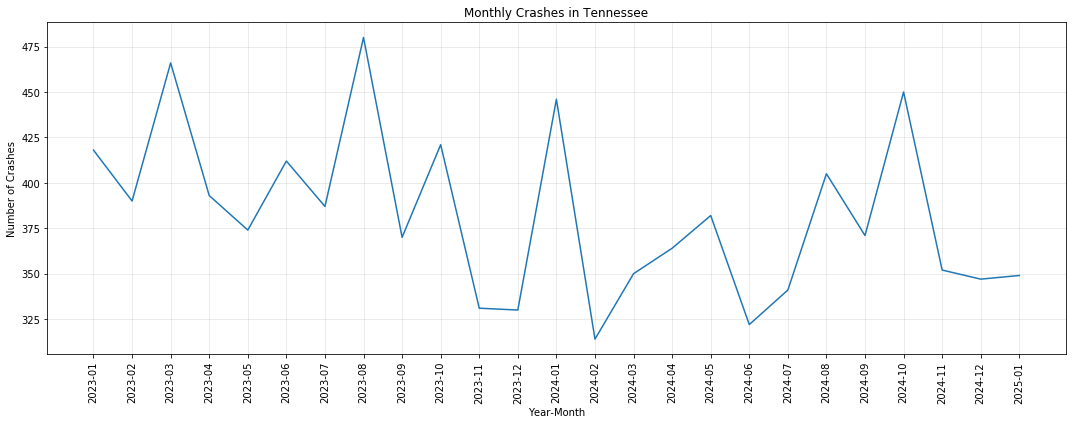

In [ ]:
# Plot TN monthly crashes
plt.figure(figsize=(15, 6))
plt.plot(tn_monthly_pd['year_month'], tn_monthly_pd['total_crashes'])
plt.xticks(rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('Number of Crashes')
plt.title('Monthly Crashes in Tennessee')
plt.grid(True, alpha=0.3)
plt.tight_layout()

There appears to be a general decreasing trend in number of crashes. At first glance, it looks like there is some sort of seasonal pattern, but the peaks and troughs of the graph do not occur at regular interval of time. 

In [ ]:
# Convert to pandas DataFrame
pandas_df = monthly_county_counts.toPandas()

# Save to a temporary local file
pandas_df.to_csv('/tmp/monthly_county_counts.csv', index=False)

In [ ]:
# Use Google Cloud SDK to copy the file to GCS
# Run this as a shell command
!gsutil cp /tmp/monthly_county_counts.csv gs://ds5460-arvelo-bucket0311/notebooks/jupyter/monthly_county_counts.csv

Copying file:///tmp/monthly_county_counts.csv [Content-Type=text/csv]...
/ [1 files][  1.1 MiB/  1.1 MiB]                                                
Operation completed over 1 objects/1.1 MiB.                                      


In [ ]:
spark.stop()

Since this is a reasonably small dataset (41,712 rows and 8 columns of mostly numeric data) and we are only moving forward using Databricks as our primary cloud environment we decided to export the preprocessed dataframe as a csv for the ease of being able to read this into DBFS for the following steps in the project. 